# **Zadanie 2**
---

# Wstęp
Celem zadania jest sprawdzenie 5 różnych metod generujących rozkład normalny $X \sim \mathcal{N}(\mu, \sigma^2)$ w tym przypadku $X \sim \mathcal{N}(0, 1)$. Pierwsze 3 metody zostały zaimplementowane z wykorzystaniem kodów przedstawianych w trakcie zajęć, są to metody: odwrotnej dystrybuanty, akceptacji odrzucenia, stosunków jenostajnych. Dwie kolejne metody "tuzina" oraz "zigguratu" zaimplementowane zostały ręcznie. Ostatnim krokiem jest porównanie wyżej wymienionych metod na podstawie: czasu działania algorytmu, zużycia pamięci oraz dokładności symulacji.

---


# Implementacja potrzebnych bibliotek oraz funckji

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import ctypes
import time
from memory_profiler import memory_usage

def Theoretical_PDF(mu=0,sigma=1):
    sample_range = (mu-4*sigma,mu+4*sigma)
    xs = np.linspace(sample_range[0],sample_range[1],10000)
    ys = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*(xs-mu)**2/sigma**2)
    return xs ,ys

x_t, y_t = Theoretical_PDF()

# Implementacja kodów z zajęć

* Zadanie 1 lista 2\
    Metoda odwróconej dystrybuanty generuje próbki z rozkładu prawdopodobieństwa, korzystając z funkcji odwrotnej dystrybuanty tego rozkładu. Najpierw losuje się wartość  $U\sim U(0,1)$ z jednorodnego rozkładu. Następnie oblicza się wartość funkcji odwrotnej dystrybuanty $F(u)=\Phi^{-1}(x)$ co daje próbkę z pożądanego rozkładu. Metoda ta jest bardzo efektywna, jeśli znana jest funkcja odwrotna dystrybuanty. Jest szczególnie przydatna w przypadku prostych rozkładów, takich jak rozkład normalny, wykładniczy, czy log-normalny.

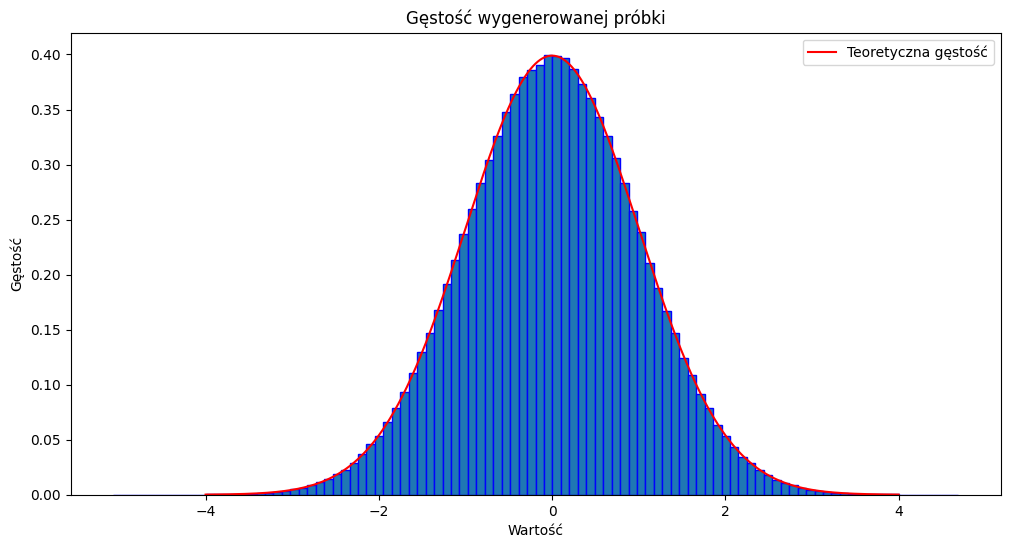

In [ ]:
class inverse_CDF():
    def __init__(self) -> None:
        pass

    def test(self,iterations,size):
        means = []
        variances = []
        for i in range(iterations):
            dane = self.generate_samples(size=size)
            means.append(np.mean(dane))
            variances.append(np.var(dane))
        return np.mean(means),np.mean(variances)
    
    def generate_samples(self,size=1e6, mu=0.0, sigma=1.0):
        """
        Generuje próbki z rozkładu noramlengo metodą odwróconej dystrubuanty.
        Args:
            size (int): Liczba próbek do wygenerowania (domyślnie 1e6).
            mu (float): Średnia rozkładu normalnego (domyslnie 0).
            sigma (float): Wariancja rozkładu normalnego (domyślnie 1).
        Returns:
            np.ndarray: Tablica próbek z rozkładu normalnego.
        """
        u = np.random.uniform(0, 1, size)
        z = norm.ppf(u, loc=mu, scale=sigma)
        return z

metoda = inverse_CDF()
dane = metoda.generate_samples(1000000)
# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.hist(dane,density=1,edgecolor='blue',bins=100)
plt.plot(x_t,y_t,label='Teoretyczna gęstość',color='r') 
plt.xlabel('Wartość')
plt.ylabel('Gęstość')
plt.title('Gęstość wygenerowanej próbki')
plt.legend()
plt.show()

# print(metoda.test(100,1000000))

Kod implementujacy działa poprawnie. Histogram danych pokrywa się z dużą dokładnością do teoretycznej gęstości. Średnia i wariancja są rzędu $1\cdot 10^{-5}$. Wyniki są satysfakcjonujące.

* Zadanie 3 lista 3\
    Metoda akceptacji odrzucenia z wykorzystaniem rozkładu wykładniczego. Generuje próbki z pożądanego rozkładu, wykorzystując inny, łatwy do próbkowania rozkład pomocniczy. Wybiera się losowy punkt z rozkładu tutaj wykładniczego, a następnie sprawdza, czy punkt ten znajduje się poniżej krzywej gęstości pożądanego rozkładu. Jeśli tak, próbka jest akceptowana; w przeciwnym razie jest odrzucana. Proces ten jest powtarzany, aż uzyska się odpowiednią liczbę próbek. Metoda ta jest skuteczna dla rozkładów, które są trudne do próbkowania bezpośrednio, ale wymaga dobrze dobranego rozkładu pomocniczego, aby minimalizować liczbę odrzuconych próbek.

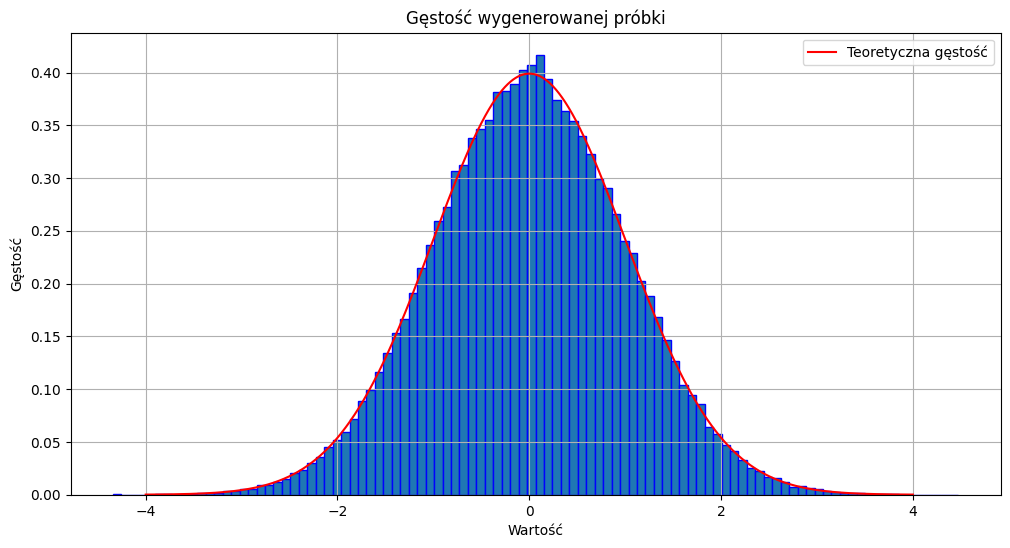

In [ ]:
class acaptnace():
    def __init__(self) -> None:
        pass
    def wykladniczy(self,beta=1, n=1000000):
        """
        Generuje próbki z rozkładu wykładniczego.
        Args:
            beta (float): Parametr skali rozkładu wykładniczego (domyślnie 1).
            n (int): Liczba próbek do wygenerowania (domyślnie 1e6).
        Returns:
            np.ndarray: Tablica próbek z rozkładu wykładniczego.
        """
        return np.random.default_rng().exponential(scale=beta, size=n)

    def generate_normal(self,n=1000000, beta=1):
        """
        Generuje próbki z rozkładu normalnego |N(0, 1)| przy użyciu metody akceptacji-odrzucania, zaczynając od rozkładu wykładniczego.
        Args:
            n (int): Liczba próbek do wygenerowania (domyślnie 1,000,000).
            beta (float): Parametr skali rozkładu wykładniczego (domyślnie 1).
        Returns:
            np.ndarray: Tablica próbek z rozkładu normalnego N(0, 1).
        """
        samples = []
        while len(samples) < n:
            x = self.wykladniczy(beta, n)
            u = np.random.uniform(0, 1, size=n)
            mask = u < np.exp(-0.5 * x**2 - 0.5 + x)
            samples.extend(x[mask])
        return np.array(samples)[:n]

    def generate_samples(self,n, mu=0, sigma=1, beta=1):
        """
        Generuje próbki z rozkładu normalnego N(mu, sigma) przy użyciu rozkładu wykładniczego i metody akceptacji-odrzucania.
        Args:
            n (int): Liczba próbek do wygenerowania.
            mu (float): Średnia rozkładu normalnego (domyślnie 0).
            sigma (float): Odchylenie standardowe rozkładu normalnego (domyślnie 1).
            beta (float): Parametr skali rozkładu wykładniczego (domyślnie 1).
        Returns:
            np.ndarray: Tablica próbek z rozkładu normalnego N(mu, sigma).
        """
        x = self.generate_normal(n, beta)
        for i in range(n):
            u = np.random.uniform(0, 1)
            j = (u > 0.5) * 2 - 1
            x[i] = x[i] * j
        x = x * sigma + mu
        return x
    
    def test(self,iterations,size):
        means = []
        variances = []
        for i in range(iterations):
            dane = self.generate_samples(n=size)
            means.append(np.mean(dane))
            variances.append(np.var(dane))
        return np.mean(means),np.mean(variances)
    
metoda = acaptnace()
dane = metoda.generate_samples(n=100000, mu=0, sigma=1, beta=1)
# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.hist(dane,density=1,edgecolor='blue',bins=100)
plt.plot(x_t,y_t,label='Teoretyczna gęstość',color='r')
plt.xlabel('Wartość')
plt.ylabel('Gęstość')
plt.title('Gęstość wygenerowanej próbki')
plt.legend()
plt.grid(True)
plt.show()

# print(metoda.test(100,1_000_000))

Generowany rozkład normalny wygląda na mniej dokładny niż wygenerowany we wcześniejszym zadaniu natomiast dalej pokrywa się w wiekszości. Większy błąd średniej oraz wariancji rzędu $1\cdot 10^{-3}$ jest widoczny. 

* Zadanie 2 lista\
Metoda stosunków jednostajnych generuje próbki z rozkładu normalnego, wykorzystując dwa losowe punkty o jednostajnym rozkładzie. Wybiera losowy punkt z kwadratu, a następnie sprawdza, czy punkt ten mieści się w obrębie jednostajnej funkcji gęstości rozkładu. Próbki, które znajdują się wewnątrz tej funkcji, są akceptowane, a te, które są poza, są odrzucane. Dzięki temu metoda jest prosta, ale ma niską wydajność, ponieważ wiele próbek jest odrzucanych. Stosowana jest głównie do szybkiego generowania danych do analizy, gdy precyzja nie jest kluczowa.

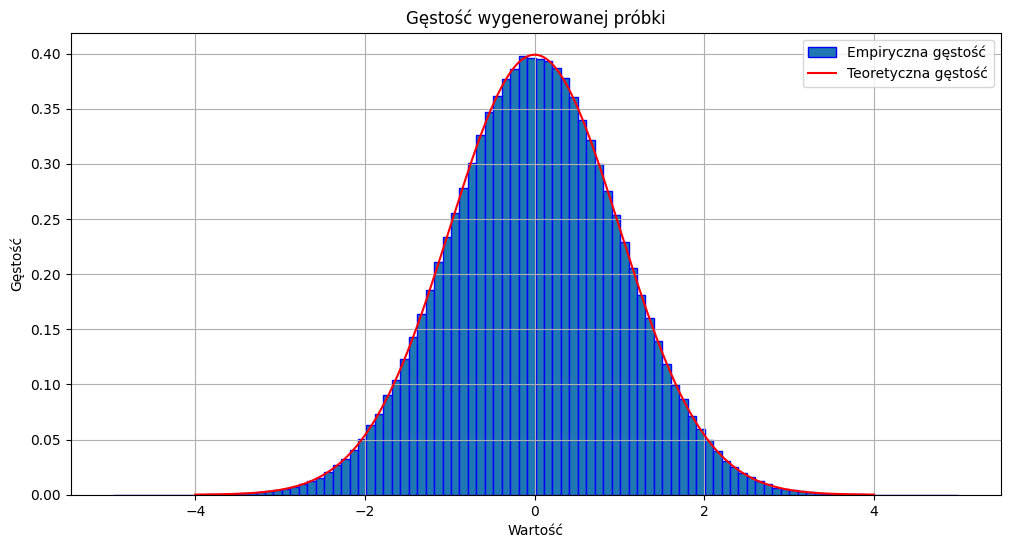

In [ ]:
class uniform_relations():
    def __init__(self) -> None:
        pass
    # Define the function to calculate the upper boundary of y
    def func(self,x):
        return 2 * x * np.sqrt(-np.log(x))

    def generate_samples(self,size):
        # Generate x values from 0.01 to 1 with 400 points
        x = np.linspace(0.01, 1, 1000)

        # Calculate the corresponding y values (upper boundary)
        y_upper = self.func(x)

        # Initialize an empty list to store generated samples
        zs = []

        # Maximum y value from the function for rejection sampling
        y_max = self.func(np.exp(-0.5))

        # Set the desired number of samples to 1 million
        num_samples = size

        # Generate samples using rejection sampling
        while len(zs) < num_samples:
            val_x = np.random.uniform(0, 1)  # Random x from uniform distribution
            closest_index = np.abs(x - val_x).argmin()  # Find the closest x in the precomputed array
            val_y = np.random.uniform(-y_max, y_max)  # Random y from uniform distribution within -y_max and y_max
            if np.abs(val_y) <= y_upper[closest_index]:  # Accept the sample if within the upper boundary
                z = val_y / val_x  # Compute z = y / x
                zs.append(z)  # Append the sample to the list

        return np.array(zs)
    
    
    def test(self,iterations,size):
        means = []
        variances = []
        for i in range(iterations):
            dane = self.generate_samples(size=size)
            means.append(np.mean(dane))
            variances.append(np.var(dane))
        return np.mean(means),np.mean(variances)


metoda = uniform_relations()
# Convert the list of samples to a NumPy array
dane = metoda.generate_samples(int(1e6))

# Apply the 5-sigma rule: keep only values within [-5, 5]
filtered_sample = dane[np.abs(dane) <= 5]
# Rysowanie wykresu
plt.figure(figsize=(12, 6))
plt.hist(filtered_sample, bins=100, density=1, edgecolor='blue', label='Empiryczna gęstość')
plt.plot(x_t, y_t, color='red', label='Teoretyczna gęstość')
plt.xlabel('Wartość')
plt.ylabel('Gęstość')
plt.title('Gęstość wygenerowanej próbki')
plt.legend()
plt.grid(True)
plt.show()

# print(metoda.test(100,1000000))


Próbki w tym przypadku nie są generowane dokładnie. Przy dużych rozmiarach danych pojawiają się wyniki wychodzące daleko poza $5\cdot \sigma$ (typu $400\cdot \sigma$), co srpawia że z wyasymilowanej próbki zostają odcięte pewne wartości a wariancja jest absurdalnie duża przekraczająca tysiąc, średnia pozostaje względnie dobrze estymowana z błedem na poziomie $1\cdot10^{-3}$ . Średnio z próbki o długości $1\cdot 10^6$ usuwanych jest $\sim 0.03\%$ wartości.

# Własnoręczne zaimplementowanie metod tuzinu i zigguratu

* Metoda tuzina\
    polega na wygenerowaniu 12 próbek z rozkładu jenostajnego po czym odjęciu od nich 6 a na koniec przemnożeniu próbki przez wariancje oraz dodanie średniej weług wzoru.
    Niech $U_i$ to będą pseudolosowe liczby z rozkładu $U\sim U(0,1)$
    1. $S=\sum^{12}_{i=1}U_i$
    2. $X = S-6$
    3. $N = \sigma X + \mu$

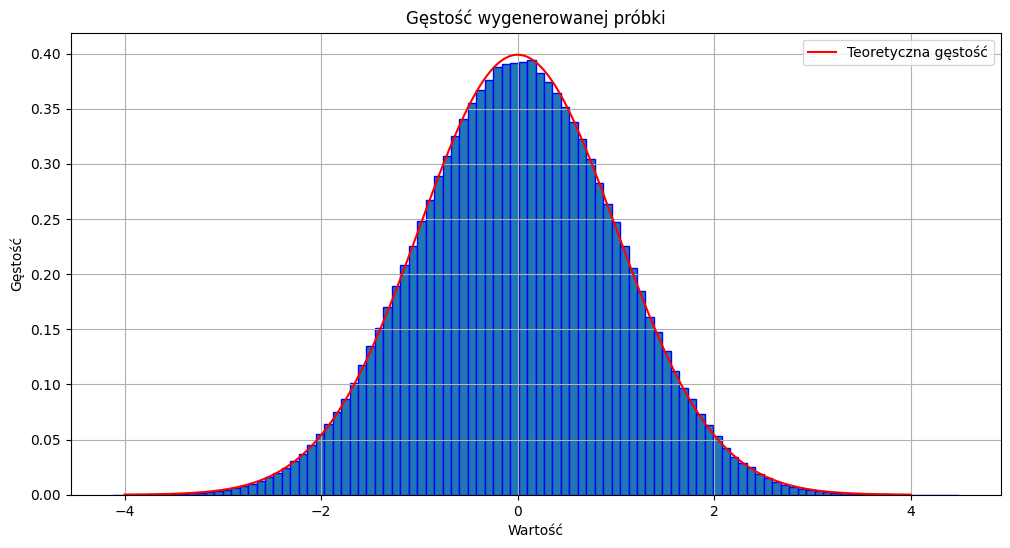

In [ ]:
class tuzin():
    """
    Klasa generująca próbki z rozkładu normalnego za pomocą metody sumy dwunastu jednostajnych (tzw. metoda tuzina).

    Metoda ta polega na generowaniu 12 liczb losowych z rozkładu jednostajnego, sumowaniu ich,
    a następnie normalizowaniu, co zgodnie z centralnym twierdzeniem granicznym daje próbki z rozkładu normalnego.
    """

    def __init__(self) -> None:
        """
        Inicjalizator klasy.
        """
        pass

    def generate_samples(self, n=int(1e6), m=0, s=1):
        """ 
        Args:
            n (int): Liczba próbek do wygenerowania (domyślnie 1e6).
            m (float): Średnia rozkładu normalnego (domyślnie 0).
            s (float): Odchylenie standardowe rozkładu normalnego (domyślnie 1).

        Returns:
            np.ndarray: Tablica próbek z rozkładu normalnego.
        """
        N = []
        for i in range(n):
            # Generowanie 12 liczb losowych z rozkładu jednostajnego U(0, 1)
            U = np.random.uniform(0, 1, 12)
            # Sumowanie 12 liczb i odejmowanie 6, co prowadzi do rozkładu normalnego ze średnią 0 i odchyleniem standardowym bliskim 1
            X = np.sum(U) - 6
            # Normalizacja próbek, aby miały zadane odchylenie standardowe s i średnią m
            N.append(s * X + m)
        return np.array(N)
    
    
    def test(self,iterations,size):
        means = []
        variances = []
        for i in range(iterations):
            dane = self.generate_samples(n=size)
            means.append(np.mean(dane))
            variances.append(np.var(dane))
        return np.mean(means),np.mean(variances)

# Tworzenie instancji klasy Tuzin
metoda = tuzin()

# Generowanie próbek z rozkładu normalnego
n_samples = int(1e6)  # Liczba próbek
m = 0  # Średnia
s = 1  # Odchylenie standardowe
standard_normal_samples_tuzin = metoda.generate_samples(n_samples, m, s)

# Rysowanie wykresu histogramu wygenerowanych próbek
plt.figure(figsize=(12, 6))
plt.hist(standard_normal_samples_tuzin, density=1, edgecolor='b', bins=100)

# Dodanie teoretycznej krzywej gęstości rozkładu normalnego do wykresu
plt.plot(x_t, y_t, color='red', label='Teoretyczna gęstość')

# Opisy osi i tytuł wykresu
plt.xlabel('Wartość')
plt.ylabel('Gęstość')
plt.title('Gęstość wygenerowanej próbki')
plt.legend()
plt.grid(True)
plt.show()

# print(metoda.test(100,1000000))

Wyliczone estymatory są raczje dobre, wyróżnia się tutaj średnia z błedem na poiomie $\sim 1\cdot10^{-4}$ wariancja z kolei odstaje z błedem $1\cdot 10^{-3}$. Znacznie leprzy wynik niż poprzedni.

* Metoda ziggurat\
    Dzieli funkcję gęstości rozkładu na prostokątne warstwy o równych powierzchniach, umożliwiając szybkie generowanie próbek poprzez losowanie punktów w tych warstwach. Z centralnych warstw rozkładu generuje się większość próbek, co zwiększa efektywność. Aby ją zastosować, należy podzielić funkcję gęstości na warstwy, a następnie losować i sprawdzać punkty pod kątem zgodności z rozkładem. Metoda ta minimalizuje liczbę odrzuconych próbek, co przyspiesza generowanie danych.

C:\Users\kacpu\AppData\Local\Temp\ipykernel_18124\307977681.py:70: RuntimeWarning: overflow encountered in scalar negative
  return 0.5 * (1.0 + new_jsr / -np.power(2, 31)), new_jsr


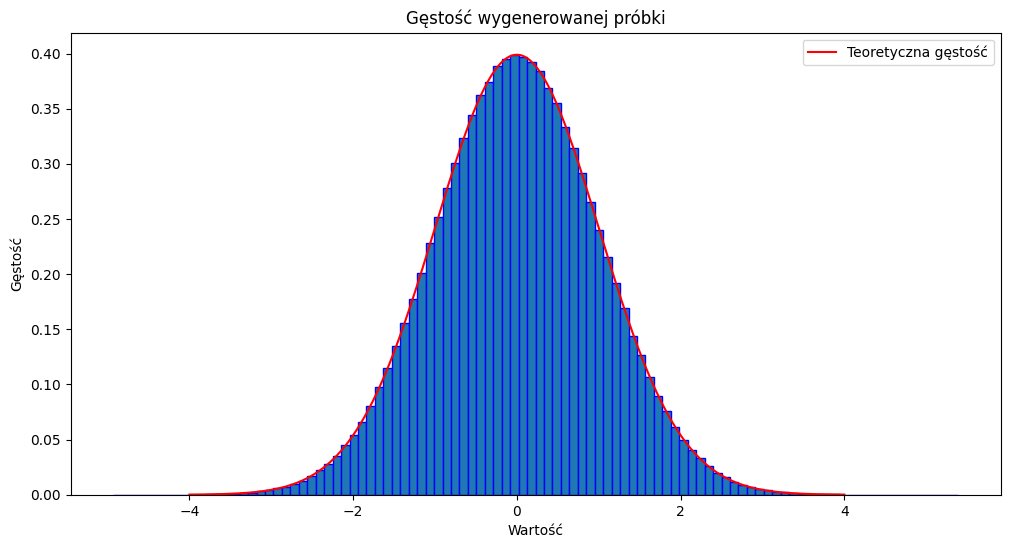

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import ctypes
import time

class ziggurat():
    """
    Klasa generująca próbki z rozkładu normalnego za pomocą metody Ziggurata.

    Metoda Ziggurata wykorzystuje tablicę prefiksów i podejście oparte na odrzuceniu.
    """

    def __init__(self, mean=0.0, std=1.0, seed=37):
        """
        Inicjalizuje generator próbek z rozkładu normalnego.

        Args:
            mean (float): Średnia rozkładu normalnego (domyślnie 0.0).
            std (float): Odchylenie standardowe rozkładu normalnego (domyślnie 1.0).
            seed (int): Ziarno losowości (domyślnie 37).
        """
        self.mean = mean
        self.std = std
        self.seed = seed

    def _rshift(self, val, n):
        """
        Przesuwa wartość val o n bitów w prawo, z uwzględnieniem znaku.

        Args:
            val: Wartość do przesunięcia.
            n (int): Liczba bitów o które przesunięto.

        Returns:
            Przesunięta wartość.
        """
        if val >= 0:
            return ctypes.c_int(val >> n).value
        else:
            return ctypes.c_int((val + 0x100000000) >> n).value

    def _shr3(self, jsr):
        """
        Implementuje algorytm SHR3.

        Args:
            jsr (int): Stan generatora liczb losowych.

        Returns:
            Nowy stan generatora oraz wygenerowaną liczbę losową.
        """
        jzr = jsr
        jzr = ctypes.c_int(jzr ^ (jzr << 13)).value
        jzr = ctypes.c_int(jzr ^ self._rshift(jzr, 17)).value
        jzr = ctypes.c_int(jzr ^ (jzr << 5)).value
        return ctypes.c_int((jsr + jzr) | 0).value, jzr

    def _uni(self, jsr):
        """
        Generuje losową liczbę z rozkładu jednostajnego na przedziale (0, 1).

        Args:
            jsr (int): Stan generatora liczb losowych.

        Returns:
            Wygenerowana liczba oraz nowy stan generatora.
        """
        jsr, new_jsr = self._shr3(jsr)
        return 0.5 * (1.0 + new_jsr / -np.power(2, 31)), new_jsr

    def _uni_safe(self, jsr):
        """
        Generuje bezpieczną losową liczbę z rozkładu jednostajnego, eliminując wartości bliskie zeru.

        Args:
            jsr (int): Stan generatora liczb losowych.

        Returns:
            Bezpieczna liczba oraz nowy stan generatora.
        """
        while True:
            u, jsr = self._uni(jsr)
            if 0 != u:
                return u, jsr

    def _nfix(self, hz, iz, wn, fn, kn, jsr):
        """
        Naprawia losową liczbę z rozkładu jednostajnego zgodnie z algorytmem Ziggurata.

        Args:
            hz (int): Stan generatora liczb losowych.
            iz (int): Indeks w tablicy prefiksów.
            wn (np.ndarray): Tablica prefiksów.
            fn (np.ndarray): Tablica wartości funkcji rozkładu.
            kn (np.ndarray): Tablica granic przedziałów.
            jsr (int): Stan generatora liczb losowych.

        Returns:
            Wygenerowana liczba oraz nowy stan generatora.
        """
        r = 3.442619855899
        r1 = 1.0 / r
        x = 0
        y = 0

        while True:
            x = hz * wn[iz]
            if iz == 0:
                x = -np.log(self._uni_safe(jsr)[0]) * r1
                y = -np.log(self._uni_safe(jsr)[0])

                while True:
                    x = -np.log(self._uni_safe(jsr)[0]) * r1
                    y = -np.log(self._uni_safe(jsr)[0])
                    if y + y >= x * x:
                        break
                return (r + x if hz > 0 else -r - x), jsr

            if fn[iz] + self._uni(jsr)[0] * (fn[iz - 1] - fn[iz]) < np.exp(-0.5 * x * x):
                return x, jsr

            hz, jsr = self._shr3(jsr)
            iz = hz & 127

            if np.abs(hz) < kn[iz]:
                return hz * wn[iz], jsr

    def generate_samples(self, size=10000):
        """
        Generuje próbki z rozkładu normalnego za pomocą metody Ziggurata.

        Args:
            size (int): Liczba próbek do wygenerowania (domyślnie 10000).

        Returns:
            np.ndarray: Tablica próbek z rozkładu normalnego.
        """
        wn = np.array([0.0 for _ in range(128)], dtype=np.float64)
        fn = np.array([0.0 for _ in range(128)], dtype=np.float64)
        kn = np.array([0.0 for _ in range(128)], dtype=np.float64)

        jsr = 123456789 ^ (self.seed if self.seed is not None else int(time.time()))

        m1 = 2147483648.0
        dn = 3.442619855899
        tn = dn
        vn = 9.91256303526217e-3

        q = vn / np.exp(-0.5 * dn * dn)
        kn[0] = np.floor((dn / q) * m1)
        kn[1] = 0

        wn[0] = q / m1
        wn[127] = dn / m1

        fn[0] = 1.0
        fn[127] = np.exp(-0.5 * dn * dn)

        i = 126
        while i >= 1:
            dn = np.sqrt(-2.0 * np.log(vn / dn + np.exp(-0.5 * dn * dn)))
            kn[i + 1] = np.floor((dn / tn) * m1)
            tn = dn
            fn[i] = np.exp(-0.5 * dn * dn)
            wn[i] = dn / m1

            i -= 1

        samples = []
        for _ in range(size):
            hz, jsr = self._shr3(jsr)
            iz = hz & 127
            sample, jsr = (hz * wn[iz], jsr) if np.abs(hz) < kn[iz] else self._nfix(hz, iz, wn, fn, kn, jsr)
            samples.append(self.mean + self.std * sample)
        return samples

    
    def test(self,iterations,size):
        means = []
        variances = []
        for i in range(iterations):
            dane = self.generate_samples(size=size)
            means.append(np.mean(dane))
            variances.append(np.var(dane))
        return np.mean(means),np.mean(variances)
# Użycie klasy Ziggurat do generowania próbek
metoda = ziggurat()
ziggurat_samples = metoda.generate_samples(size=1000000)

# Wyświetlenie histogramu
plt.figure(figsize=(12, 6))
plt.hist(ziggurat_samples, bins=100, density=True, edgecolor="b")
plt.plot(x_t,y_t,label='Teoretyczna gęstość',color='r')
plt.xlabel('Wartość')
plt.ylabel('Gęstość')
plt.title('Gęstość wygenerowanej próbki')
plt.legend()
plt.show()

# print(metoda.test(100,1000000))

Ta mtoda była w stanie generować jedne z najbardziej dokładnych histogramów, przkłada się to na dokładnośc obu estymatorów. Błedy wynoszą $\sim 1\cdot 10^{-4}$

# Test różnych generatorów
---

* Test czasowy\
    W celu analizy czasowej różnych metod zaprogramowana została funkcja mierząca różnicę czasu między wywołaniem a zakończeniem działania każdej z funkcji. zrobione to zostało dzięki sprowadzeniu kazdej metody do swojej klasy. Czasy zostały zmierzone na danych rozpinających sie od $1\cot 10^5$ do $1\cdot 10^6$ ze skokiem o $1\cdot 10^5$, przy każym rozmiarze danych powtórzono test $10$-krotnie wyliczając średnią.

C:\Users\kacpu\AppData\Local\Temp\ipykernel_18124\307977681.py:70: RuntimeWarning: overflow encountered in scalar negative
  return 0.5 * (1.0 + new_jsr / -np.power(2, 31)), new_jsr


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


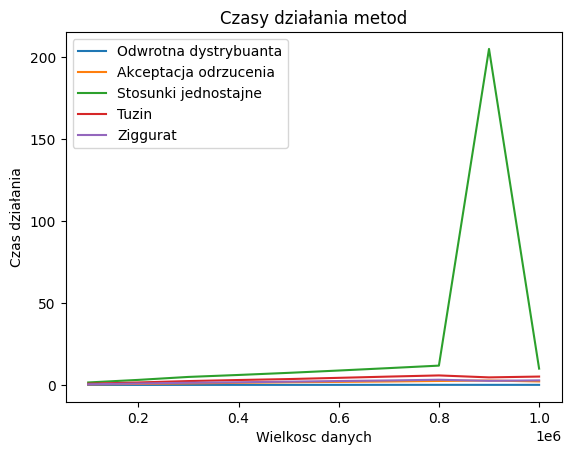

In [ ]:
def measure_execution_time(size, class_type):
    total_time = 0
    iterations = 10

    if class_type == 1:
        obj = inverse_CDF()
    elif class_type == 2:
        obj = acaptnace()
    elif class_type == 3:
        obj = uniform_relations()
    elif class_type == 4:
        obj = tuzin()
    elif class_type == 5:
        obj = ziggurat()
    else:
        raise ValueError("Invalid class type provided")

    for _ in range(iterations):
        start_time = time.time()
        d = obj.generate_samples(size)
        end_time = time.time()
        total_time += end_time - start_time

    total_time /= iterations

    return total_time

N = np.arange(int(1e5),int(1e6)+1,int(1e5))
times_1 = []
times_2 = []
times_3 = []
times_4 = []
times_5 = []

for n in N:
    times_1.append(measure_execution_time(n,1))
    times_2.append(measure_execution_time(n,2))
    times_3.append(measure_execution_time(n,3))
    times_4.append(measure_execution_time(n,4))
    times_5.append(measure_execution_time(n,5))

plt.figure(figsize=(14, 8))
plt.plot(N,times_1,label='Odwrotna dystrybuanta')
plt.plot(N,times_2,label='Akceptacja odrzucenia')
plt.plot(N,times_3,label='Stosunki jednostajne')
plt.plot(N,times_4,label='Tuzin')
plt.plot(N,times_5,label='Ziggurat')
plt.ylabel("Czas działania")
plt.xlabel("Wielkosc danych")
plt.title("Czasy działania metod")
plt.legend()

Widoczny wykres jednoznacznie wskazuje, że każda metoda ma charakter liniowy $O(n)$. Najlepiej wypadły metody: a najgorzej 

* Test zużycia pamięci\
    Nie rózni się znacząco od poprzedniego, funkcja działa tak samo lecz liczy zużycie pamięci.

C:\Users\kacpu\AppData\Local\Temp\ipykernel_18124\307977681.py:70: RuntimeWarning: overflow encountered in scalar negative
  return 0.5 * (1.0 + new_jsr / -np.power(2, 31)), new_jsr


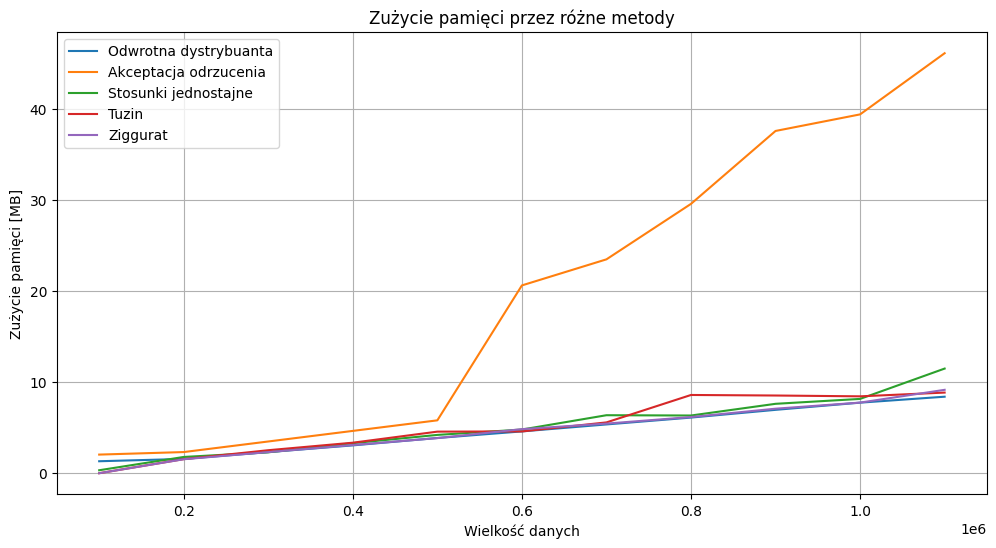

In [ ]:
def measure_memory_usage(size, class_type):
    """
    Mierzy zużycie pamięci przez funkcję generującą próbki dla zadanej klasy.

    Args:
        size (int): Wielkość generowanych danych.
        class_type (int): Typ klasy (1-5).

    Returns:
        list: Lista zużycia pamięci dla każdego wywołania.
    """
    memories = []
    iterations = 10

    # Inicjalizacja obiektu na podstawie class_type
    if class_type == 1:
        obj = inverse_CDF()
    elif class_type == 2:
        obj = acaptnace()
    elif class_type == 3:
        obj = uniform_relations()
    elif class_type == 4:
        obj = tuzin()
    elif class_type == 5:
        obj = ziggurat()
    else:
        raise ValueError("Invalid class type provided")

    # Mierzenie zużycia pamięci dla 10 iteracji
    for _ in range(iterations):
        mem_usage = memory_usage((obj.generate_samples, (size,)), max_iterations=1)
        memories.append(max(mem_usage) - min(mem_usage))

    return memories

# Zakresy rozmiarów danych
N = np.arange(int(1e5), int(1e6) + int(1e5)+1, int(1e5))

# Wyniki
results = {1: [], 2: [], 3: [], 4: [], 5: []}

# Zbieranie danych
for n in N:
    for class_type in range(1, 6):
        results[class_type].append(measure_memory_usage(n, class_type))

# Rysowanie wykresów
plt.figure(figsize=(12, 6))

# Iteracja przez typy klas i rysowanie wyników zużycia pamięci
for class_type, label in zip(range(1, 6), [
        'Odwrotna dystrybuanta', 
        'Akceptacja odrzucenia', 
        'Stosunki jednostajne', 
        'Tuzin', 
        'Ziggurat']):
    memories = [np.mean(result) for result in results[class_type]]  # Średnie zużycie pamięci dla każdej klasy
    plt.plot(N, memories, label=label)

plt.ylabel("Zużycie pamięci [MB]")
plt.xlabel("Wielkość danych")
plt.title("Zużycie pamięci przez różne metody")
plt.legend()
plt.grid(True)
plt.show()

Zużycie pamięci systemu jest trudne pomiary przez ograniczenie systemu winows natomiast możemy wyróżnić metodę akceptacji odrzucenie co nie dziwi nas biorąc pod uwagę odrzucanie nieudanych prób. Pozostałe metody trzymaja sie blisko siebie jednak widoczne jest odstepstwo metody stosunków oraz tuzina. Na uwagę zasługują metoda zigguratu oraz odwróconej dystrybuanty mające najmniejsze zużycie pamięci.

---
# Podsumowanie

W zadaniu zostały porównane rózne metody generujące rozkład standardowy normalny. Każda z nich jest ma swoje zalety i way w zależności od kryterium oceny. Najlepszymi algorytmami według rankingu i przypisywanych im ocen są algorytmy: odwrotnej dystrybuanty, ziggurat, tuzin, akceptacji odrzucenia, stosunkow jednostajncyh. Szególnie odznacza się metoda odwrotnej dystrybuanty uzyskujac najlepsze wyniki wszędzie. Metoda akceptacji ma dużą dokładność, a ziggurat małe zużycie pamięci i dużą szybkość, jednak dokładnośc nieustępuje metodzie tuzina, który jest gorszy na wscześniej wymienionych polach.